In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from numpy import median,mean
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact,interactive,fixed,interact_manual
import ipywidgets as widgets
from IPython.display import display
import matplotlib.ticker as mtick
from ipywidgets import SelectMultiple

In [2]:
#Import Data from BasketballReference.com
##Data sets for Team Names, Player Season Total Stats per Season, Team Total Stats per Season, Team Records per Season
TeamNames = pd.read_csv('TeamNames.csv')
PlayerTotals = pd.read_csv('NBAPlayerTotals.csv',thousands=',')
TeamTotals = pd.read_csv('NBATeamTotals.csv',thousands=',')
Records = pd.read_csv('NBATeamRecords.csv',thousands=',')

##Tidying up data
TeamTotals.rename(columns={'Unnamed: 0':'Season'},inplace=True)
Records = Records[~Records.Season.str.contains('18')]
Records['Year'] = Records.Season.str.slice(0,4)
Records.sort_values('Year',ascending=True)
Records = Records.sort_values(['Year'],ascending=True).reset_index(drop=True)

#Segment teams per season by Win percentage into groups of 5 and groups of three. The purpose of this is to identify behavior of high-win teams vs. low-win teams, per season.
Records['Quintile_Values'] = pd.cut(Records.win_pct,5)
Records['Quintile'] = pd.cut(Records.win_pct,5,labels=['Lowest','SecondLowest','Middle','SecondHighest','Highest'])
Records['Tertile_Values'] = pd.cut(Records.win_pct,3)
Records['Tertile'] = pd.cut(Records.win_pct,3,labels=['Lowest','Middle','Highest'])
tertile_colors = {'Highest':'seagreen','Middle':'darkorange','Lowest':'firebrick'}
Records['TertileSeason'] = Records['Tertile'].astype(np.str)+Records["Season"]

#Merge data sets
PlayerTotals = pd.merge(PlayerTotals,TeamNames,how='inner',left_on='Tm',right_on='TeamAbbrev',copy=False)
TeamTotals = TeamTotals.merge(Records,how='inner',left_on=['Team','Season'],right_on=['Team','Season'],copy=False)

#Cleaning data
TeamTotals = TeamTotals.sort_values(['Year'],ascending=True).reset_index(drop=True)
Records = Records[Records.columns.drop(Records.filter(regex='Unnamed'))]

In [3]:
#New rate metrics
TeamTotals['AST_TO_TOV']=TeamTotals['AST']/TeamTotals['TOV'] #Assists to Turnover Ratio
TeamTotals['PCT_PTS_FROM_3P'] = (TeamTotals['3P']*3)/TeamTotals['PTS'] #Percent of a team's points from made 3-point field goals
TeamTotals['PCT_PTS_FROM_2P'] = (TeamTotals['2P']*2)/TeamTotals['PTS'] #Percent of a team's points from made 2-point field goals
TeamTotals['PCT_PTS_FROM_FT'] = (TeamTotals['FT'])/TeamTotals['PTS'] #Percent of a team's points from made free throws
TeamTotals['FTA_per_FGA'] = TeamTotals['FTA']/TeamTotals['FGA'] #Free throw attempts per field goal attempt
TeamTotals['ORB_per_Missed_FGA'] = TeamTotals['ORB']/(TeamTotals['FGA'] - TeamTotals['FG']) #Missed field goal attempts that result in offensive rebounds
TeamTotals['AST_TO_FG'] = TeamTotals['AST']/TeamTotals['FG'] #Percentage of field goals that had an assist
TeamTotals.select_dtypes(include='number').columns

#Creating a list of columns that will be used for charts
key_TeamTotals_columns= list(['FG_PCT','3P_PCT','2P_PCT','FT_PCT','win_pct', 'AST_TO_TOV','AST_TO_FG',
       'PCT_PTS_FROM_3P', 'PCT_PTS_FROM_2P', 'PCT_PTS_FROM_FT','FTA_per_FGA','ORB_per_Missed_FGA'])

key_Seasons = list(['1989-90', '1994-95', '1999-00', '2004-05', '2009-10', '2014-15',
       '2019-20'])

In [4]:
#Creating 'TopTertileMeans' among teams in the tertile with the most wins
TopTertileMeans = TeamTotals[TeamTotals['Tertile'] == 'Highest'].groupby('Season')[key_TeamTotals_columns].mean()
TopTertileMeans['Season'] = TopTertileMeans.index
TopTertileMeans = TopTertileMeans.rename_axis(None).rename_axis(None,axis=1)
TopTertileMeans = TopTertileMeans.stack().reset_index()
TopTertileMeans.columns = ['Season','Metric','Mean']

#Creating 'BottomTertileMeans' among teams in the tertile with the lowest win percentage
BottomTertileMeans = TeamTotals[TeamTotals['Tertile'] == 'Lowest'].groupby('Season')[key_TeamTotals_columns].mean()
BottomTertileMeans['Season'] = BottomTertileMeans.index
BottomTertileMeans = BottomTertileMeans.rename_axis(None).rename_axis(None,axis=1)
BottomTertileMeans = BottomTertileMeans.stack().reset_index()
BottomTertileMeans.columns = ['Season','Metric','Mean']

#Merged top & bottom tertile mean tables into a singular 'TertileMeans' dataframe
TertileMeans = pd.merge(TopTertileMeans,BottomTertileMeans,left_on=['Season','Metric'],right_on=['Season','Metric'],suffixes=('_TopTertile','_BottomTertile'))
TertileMeans = TertileMeans[~TertileMeans.Metric.str.contains('Season')]
TertileMeans['Difference'] = TertileMeans['Mean_TopTertile']-TertileMeans['Mean_BottomTertile']
TertileMeans['Dif_Pct_Points'] = TertileMeans['Difference']*100
TertileMeans.head()

,Season,Metric,Mean_TopTertile,Mean_BottomTertile,Difference,Dif_Pct_Points
0,1989-90,FG_PCT,0.490111,0.457,0.0331111,3.31111
1,1989-90,3P_PCT,0.326222,0.289286,0.0369365,3.69365
2,1989-90,2P_PCT,0.503333,0.467,0.0363333,3.63333
3,1989-90,FT_PCT,0.775889,0.743,0.0328889,3.28889
4,1989-90,win_pct,0.685637,0.256098,0.429539,42.9539


In [5]:
#Dual-axis chart (by season) with a pointplot (showing tertile mean performance by metric selected) and a bar chart (showing the difference in metric performance between the Top & Bottom tertile (in percentage points))
def team_metric_correlations(x):
    sns.set(font_scale=1.5,style='white')
    fig, axs1 = plt.subplots(figsize=(12,8))
    axs1.set_title('Tertile Performance Differences for '+x, fontweight = 'bold',fontsize=20)
    axs1.set_xlabel('Percentage',fontsize=18)
    axs1 = sns.pointplot(x='Season',y=x,data=TeamTotals,hue='Tertile',join=False,dodge=True,ci=90,palette=tertile_colors,scale=2)
    sns.despine(right=True)
    axs2 = axs1.twinx()
    axs2 = sns.barplot(x='Season',y='Difference',data=TertileMeans[TertileMeans['Metric'] == x],alpha=.2,color='grey')
    axs1.set_ylabel("Tertile's Mean "+x+" (Point Plot)")
    axs2.set_ylabel("Difference between Top and Bottom Tertile (Bars)")
    if x != 'AST_TO_TOV':
        axs1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
        axs2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,decimals=1))
    plt.show()

interactive_plot = interactive(team_metric_correlations,x=key_TeamTotals_columns,y=TeamTotals['win_pct'])
interactive_plot

interactive(children=(Dropdown(description='x', options=('FG_PCT', '3P_PCT', '2P_PCT', 'FT_PCT', 'win_pct', 'A…

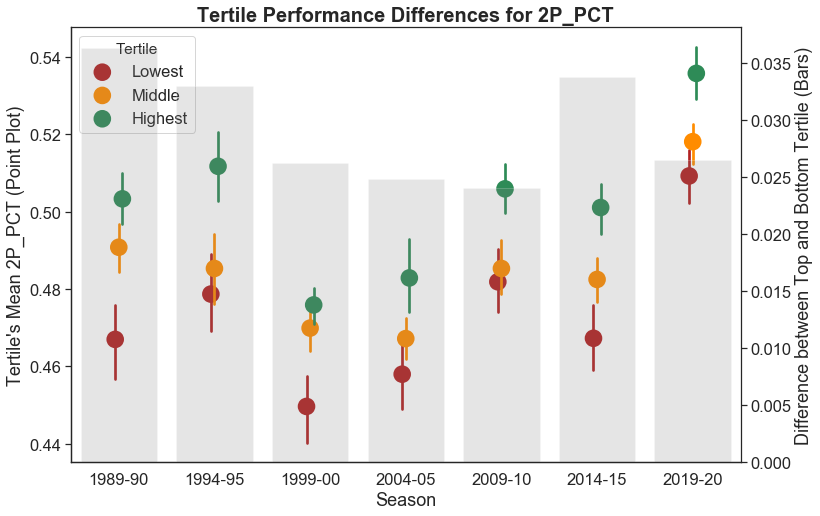

In [7]:
#Dual-axis chart with 2P Shooting Percentage
sns.set(font_scale=1.5,style='white')
fig, axs1 = plt.subplots(figsize=(12,8))
axs1.set_title('Tertile Performance Differences for '+'2P_PCT', fontweight = 'bold',fontsize=20)
axs1.set_xlabel('Percentage',fontsize=18)
axs1 = sns.pointplot(x='Season',y='2P_PCT',data=TeamTotals,hue='Tertile',join=False,dodge=True,ci=90,palette=tertile_colors,scale=2)
sns.despine(right=True)
axs2 = axs1.twinx()
axs2 = sns.barplot(x='Season',y='Difference',data=TertileMeans[TertileMeans['Metric'] == '2P_PCT'],alpha=.2,color='grey')
axs1.set_ylabel("Tertile's Mean "+'2P_PCT'+" (Point Plot)")
axs2.set_ylabel("Difference between Top and Bottom Tertile (Bars)")
plt.show()

In [8]:
TertileMeans[TertileMeans['Metric'] == '3P_PCT']

,Season,Metric,Mean_TopTertile,Mean_BottomTertile,Difference,Dif_Pct_Points
1,1989-90,3P_PCT,0.326222,0.289286,0.0369365,3.69365
14,1994-95,3P_PCT,0.376375,0.337714,0.0386607,3.86607
27,1999-00,3P_PCT,0.360273,0.340833,0.0194394,1.94394
40,2004-05,3P_PCT,0.365,0.3385,0.0265,2.65
53,2009-10,3P_PCT,0.363667,0.341222,0.0224444,2.24444
66,2014-15,3P_PCT,0.363091,0.336571,0.0265195,2.65195
79,2019-20,3P_PCT,0.364,0.34475,0.01925,1.925


In [9]:
def team_metric_correlations(x):
    print(TertileMeans[TertileMeans['Metric']==x][['Season','Dif_Pct_Points']].transpose())
interactive_plot = interactive(team_metric_correlations,x=key_TeamTotals_columns,y=TeamTotals['win_pct'])
interactive_plot

interactive(children=(Dropdown(description='x', options=('FG_PCT', '3P_PCT', '2P_PCT', 'FT_PCT', 'win_pct', 'A…

In [10]:
TT_medians = TeamTotals.groupby('Season')[key_TeamTotals_columns].median()
TT_medians['Season']=TT_medians.index
TT_corr = TeamTotals.groupby('Season')[key_TeamTotals_columns].corrwith(TeamTotals['win_pct'])
TT_corr['Season']=TT_corr.index

In [11]:
#Grouped TeamTotals dataframe by Tertile By Season to create tables with the median metric performance (TT_medians) and correlation to winning (TT_corr)
TT_medians = TeamTotals.groupby('Season')[key_TeamTotals_columns].median()
TT_medians['Season']=TT_medians.index
TT_corr = TeamTotals.groupby('Season')[key_TeamTotals_columns].corrwith(TeamTotals['win_pct'])
TT_corr['Season']=TT_corr.index
TT_corr = TT_corr.rename_axis(None).rename_axis(None,axis=1)
corr_df = TT_corr.stack().reset_index()
corr_df.columns = ['Season','Metric','Correlation']
corr_df = corr_df[~corr_df.Metric.str.contains('Season')]
corr_df = corr_df[~corr_df.Metric.str.contains('WIn',case=False)]
pd.to_numeric(corr_df['Correlation'])
corr_df['StartYear'] = corr_df['Season'].str[0:4]
corr_df['YearEnding'] = pd.to_numeric(corr_df['StartYear'])+1
corr_df.drop(columns='StartYear',inplace=True)
corr_df.head()

,Season,Metric,Correlation,YearEnding
0,1989-90,FG_PCT,0.725407,1990
1,1989-90,3P_PCT,0.365477,1990
2,1989-90,2P_PCT,0.726934,1990
3,1989-90,FT_PCT,0.376609,1990
5,1989-90,AST_TO_TOV,0.413781,1990


In [12]:
TT_corr.drop(columns='win_pct',inplace=True)
TT_corr_rank = TT_corr.rank(ascending=False,axis=1)
TT_corr_rank.transpose()


,1989-90,1994-95,1999-00,2004-05,2009-10,2014-15,2019-20
FG_PCT,2.0,2.0,1.0,3.0,2.0,2.0,2.0
3P_PCT,6.0,3.0,5.0,2.0,4.0,3.0,3.0
2P_PCT,1.0,4.0,2.0,1.0,1.0,1.0,1.0
FT_PCT,5.0,8.0,6.0,7.0,10.0,7.0,7.0
AST_TO_TOV,3.0,1.0,3.0,4.0,3.0,4.0,4.0
AST_TO_FG,7.0,5.0,4.0,9.0,6.0,6.0,10.0
PCT_PTS_FROM_3P,8.0,7.0,9.0,5.0,7.0,5.0,6.0
PCT_PTS_FROM_2P,11.0,11.0,8.0,11.0,11.0,11.0,11.0
PCT_PTS_FROM_FT,9.0,10.0,10.0,8.0,8.0,10.0,8.0
FTA_per_FGA,4.0,6.0,7.0,6.0,5.0,8.0,5.0


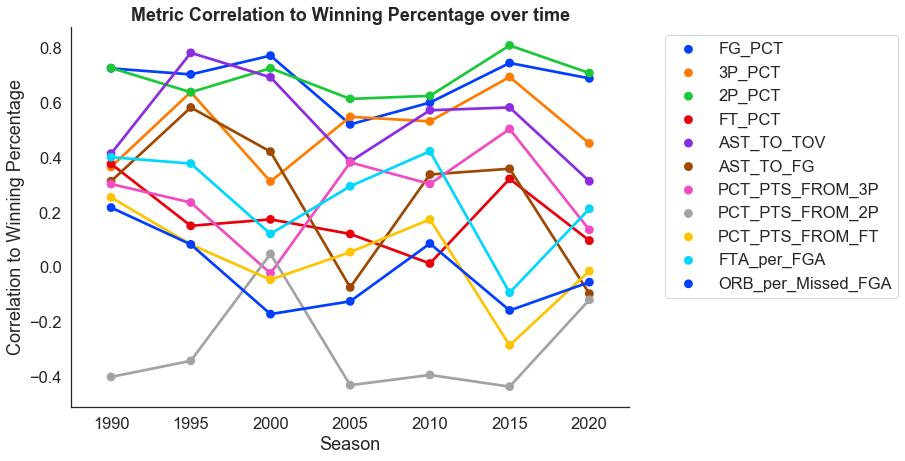

In [13]:
#Lineplot depicting the correlation of each metric to winning percentage, over time
fig, ax = plt.subplots(figsize=(10,7))
sns.pointplot(x='YearEnding',y='Correlation',hue='Metric',data=corr_df,palette='bright')
sns.despine()
sns.set_style('ticks',{'xtick.major.size':8})
ax.set_xlabel('Season')
ax.set_title('Metric Correlation to Winning Percentage over time',fontweight='bold')
ax.set_ylabel('Correlation to Winning Percentage')
plt.legend(bbox_to_anchor=(1.05,1),loc=2)
fig.savefig('Winning_Correlation2.png')


In [14]:
#Dual-axis chart depicting median metric performance by season (barplot) and metric's correlation to winning (lineplot)
def corr_median_chart(x):
    fig, ax1 = plt.subplots(figsize=(12,9))
    ax1.set_title('Median '+x+'(bars) and Correlation to Winning (lineplot)', fontsize = 24, fontweight = 'bold')
    ax1.set_xlabel('Season',fontsize=18)
    ax1.set_ylabel('Median '+x+' (bar chart)',fontsize=18)
    ax1 = sns.barplot(x='Season',y=x,data=TT_medians,alpha=.6)
    ax2 = ax1.twinx()
    ax2 = sns.lineplot(x='Season',y=x,data=TT_corr,linewidth=5)
    ax2.set_ylabel("Metric's Correlation to Win Percentage (lineplot)", fontsize=18)
    plt.tight_layout()
    plt.show()

interactive_plot = interactive(corr_median_chart,x=key_TeamTotals_columns)
interactive_plot


interactive(children=(Dropdown(description='x', options=('FG_PCT', '3P_PCT', '2P_PCT', 'FT_PCT', 'win_pct', 'A…

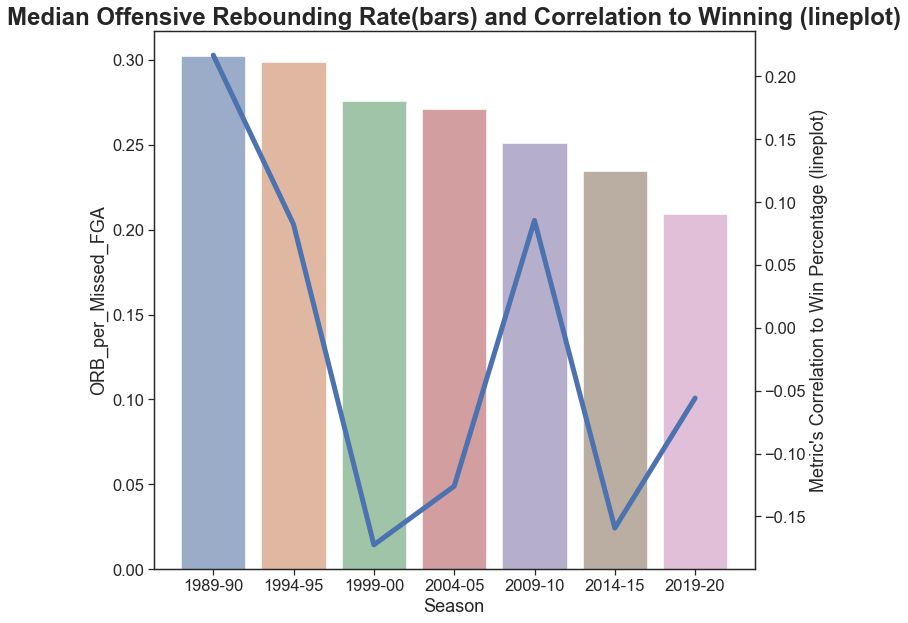

In [15]:
#Dual-axis chart for Offensive Rebounding Rate depicting median metric performance by season (barplot) and metric's correlation to winning (lineplot)

fig, ax1 = plt.subplots(figsize=(12,9))
ax1.set_title('Median '+'Offensive Rebounding Rate'+'(bars) and Correlation to Winning (lineplot)', fontsize = 24, fontweight = 'bold')
ax1.set_xlabel('Season',fontsize=18)
ax1.set_ylabel('Median '+'Offensive Rebounding Rate'+' (bar chart)',fontsize=18)
ax1 = sns.barplot(x='Season',y='ORB_per_Missed_FGA',data=TT_medians,alpha=.6)
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='Season',y='ORB_per_Missed_FGA',data=TT_corr,linewidth=5)
ax2.set_ylabel("Metric's Correlation to Win Percentage (lineplot)", fontsize=18)
plt.tight_layout()
plt.show()


In [17]:
#Transposing TT_corr dataset
TT_corr.drop(axis=1,columns='Season',inplace=True)
TT_corr_transpose = TT_corr.transpose()
TT_corr_transpose['Metric'] = TT_corr_transpose.index
TT_corr_transpose.sort_values('2019-20',ascending=False,inplace=True)


In [18]:
def corr_bars(x):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title('Correlation to winning by Season: '+x)
    ax.set_ylabel('Correlation to Winning')
    ax = sns.barplot(y='Metric',x=x,data=TT_corr_transpose)
    ax.set_xlabel('Correlation to Winning')
    plt.tight_layout()
    plt.show()


interactive_plot = interactive(corr_bars,x=key_Seasons)
interactive_plot


interactive(children=(Dropdown(description='x', options=('1989-90', '1994-95', '1999-00', '2004-05', '2009-10'…

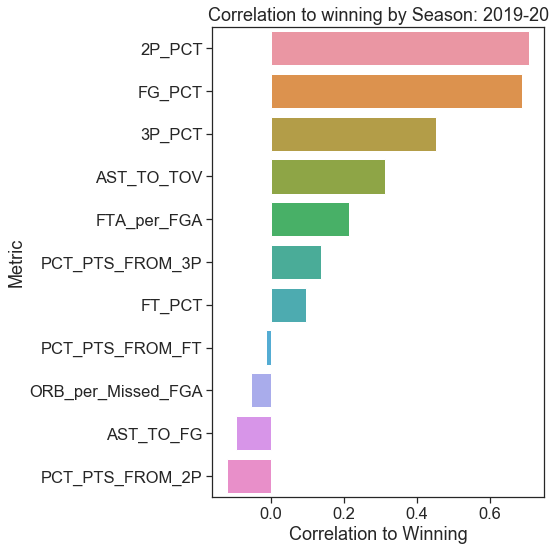

In [19]:
#Metric correlation to winning in the latest season
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Correlation to winning by Season: '+'2019-20')
ax.set_ylabel('Correlation to Winning')
ax = sns.barplot(y='Metric',x='2019-20',data=TT_corr_transpose)
ax.set_xlabel('Correlation to Winning')
plt.tight_layout()
plt.show()
